## Когортный анализ метрик проекта для компании Fenomen Games

Тестовое задание сформировано на основе данных проекта Fancy Blast. Fancy Blast это казуальная игра в жанре m3 и сказочном сеттинге.
Перед выполнением тестового задания рекомендуется познакомится с проектом и пройти первые 20 уровней. Ссылки на проект:

●	ios - https://apps.apple.com/ru/app/fancy-blast-%D0%B8%D0%B3%D1%80%D0%B0-%D1%82%D1%80%D0%B8-%D0%B2-%D1%80%D1%8F%D0%B4/id1161747978

●	google play - https://play.google.com/store/apps/details?id=com.fenomen.redhoodf2p&hl=ru&gl=US

В проекте был проведен АБ тест. 
Когорта А - контрольная, 
когорта В - когорта, у которой было уменьшено время восстановления одной жизни в 10 раз с 30 минут до 3 минут. 
В рамках тестового задания необходимо проанализировать как на метриках проекта сказалось уменьшение скорости восстановления жизней. 

В прикрепленных данных представлены следующие поля:

●	Retention - день жизни пользователя;

●	MaxLevelPassed - максимальный пройденный м3 уровень;

●	User_id - идентификатор пользователя;

●	AB_Cohort - когорта теста;

●	SumRevenue - доход от пользователя;

●	CountBuy - количество покупок;

●	CountAllStart - количество всех стартов м3 уровней;

●	CountAllFinish - количество всех побед на м3 уровнях;

●	CountCleanStart - количество стартов м3 уровней без использования всех видов помощи (докупки ходов, использования бонусов и бустеров);

●	CountCleanFinish - количество побед в м3 уровнях без использования всех видов помощи (докупки ходов, использования бонусов и бустеров);

●	Get_Ads - получение золота за просмотр рекламы;

●	Get_Chapter - получение золота в награду за прохождение глав;

●	Get_Buy - получение золота из покупки;

●	Get_Faceb - получение золота за логин в фейсбук;


●	Get_TeamL - получение золота за отправку жизней в команде;

●	Get_TeamT - получение золота за прохождение туториала на команды;

●	Spend_BonLives - траты золота на покупку жизней для бонусных глав;

●	Spend_Bonus - траты золота на покупку бонусов;

●	Spend_Boost - траты золота на покупку бустеров;

●	Spend_Lives	- траты золота на покупку жизней;

●	Spend_Moves - траты золота на покупку ходов;

●	Spend_TeamC- траты золота на создание команды;

Это смоделированные данные, на основе реальных данных. Это данные пользователей за 7 полных дней жизни (день установки считается нулевым днём).


### Часть 1. Изучение общей информации о предоставленном датасете, добавление данных

После ознакомления с проектом приступаем к анализу данных.

In [1]:
import pandas as pd
pd.options.display.max_columns = None
import matplotlib.pyplot as plt
from scipy import stats as st
import pandas_profiling
import re

In [2]:
df = pd.read_excel(r'Тестовое - данные.xlsx')

В соответствии с PEP 8, приведем названия столбцов к snake_case.

In [3]:
def make_it_snake_case(data):
    
    '''Функция приводит названия столбцов к snake_case используя регулярное выражение.'''
    
    new_columns = []
    for column in data.columns:
        column = re.sub(r'([a-z0-9])([A-Z])', r'\1_\2', column).lower()
        column = column.replace('__', '_')
        new_columns.append(column)
    data.columns = new_columns

In [4]:
make_it_snake_case(df)

Разделим предоставленные данные на два датасета, по когортам.

In [5]:
cohort_a, cohort_b = [x for _, x in df.groupby(df['ab_cohort'] != 'A')]

Для большей репрезентативности прогресса пользователя в игре добавим колонку с количеством пройденных уровней за день.

In [6]:
def add_level_progress_column(dataframe):
    
    '''
    Функция добавляет колонку с количеством пройденных уровней за день, 
    в вычислениях отталкиваемся от максимального пройденного уровня.
    
    '''
    
    data = dataframe[['retention', 'user_id', 'max_level_passed']].groupby(by=['user_id', 'retention']).sum()
    data['shifted'] = data.groupby(level=0)['max_level_passed'].shift(1)
    data.fillna(0, inplace=True)
    data['level_progress'] = (data['max_level_passed'] - data['shifted']).astype(int)
    
    data[data < 0] = 0 # в связи с особенностями сбора данных, значения max_level_passed
                       # не всегда идут по возрастанию, обрабатываем эти случаи
        
    dataframe = dataframe.join(data['level_progress'], on=['user_id','retention'])
    return dataframe

In [7]:
cohort_a = add_level_progress_column(cohort_a)
cohort_b = add_level_progress_column(cohort_b)

In [8]:
cohort_list = [cohort_a, cohort_b]
cohort_names = ['cohort_a', 'cohort_b']

Для контроля правильности выведем полученные данные, а также общую информацию и описание датасета.

In [9]:
for i in range(len(cohort_list)):
    print(f'Первые 5 строк датафрейма {cohort_names[i]}')
    display(cohort_list[i].head())
    print('-'*80)
    print(f'Типы данных и общая информация {cohort_names[i]}')
    print(cohort_list[i].info())
    print('-'*80)
    print(f'Наличие пропусков {cohort_names[i]}')
    print(cohort_list[i].isna().sum())
    print('-'*80)
    print(f'Статистические данные {cohort_names[i]}')
    display(cohort_list[i].describe())
    print('-'*80)
    print(f'Размер датасета {cohort_names[i]}')
    display(cohort_list[i].shape)
    print('-'*80)
    print(f'Количество уникальных пользователей {cohort_names[i]}')
    display(cohort_list[i]['user_id'].nunique())
    print('-'*80)

Первые 5 строк датафрейма cohort_a


,retention,max_level_passed,user_id,ab_cohort,sum_revenue,count_buy,count_all_start,count_all_finish,count_clean_start,count_clean_finish,get_ads,get_chapter,get_buy,get_faceb,get_team_l,get_team_t,spend_bon_lives,spend_bonus,spend_boost,spend_lives,spend_moves,spend_team_c,level_progress
0,0,46,1,A,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,46
1,0,46,2,A,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,46
2,0,15,3,A,0,0,18,15,14,11,0,0,0,0,0,0,0,0,0,0,0,0,15
3,0,3,4,A,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3
4,0,35,5,A,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,35


--------------------------------------------------------------------------------
Типы данных и общая информация cohort_a
<class 'pandas.core.frame.DataFrame'>
Int64Index: 12684 entries, 0 to 12683
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   retention           12684 non-null  int64 
 1   max_level_passed    12684 non-null  int64 
 2   user_id             12684 non-null  int64 
 3   ab_cohort           12684 non-null  object
 4   sum_revenue         12684 non-null  int64 
 5   count_buy           12684 non-null  int64 
 6   count_all_start     12684 non-null  int64 
 7   count_all_finish    12684 non-null  int64 
 8   count_clean_start   12684 non-null  int64 
 9   count_clean_finish  12684 non-null  int64 
 10  get_ads             12684 non-null  int64 
 11  get_chapter         12684 non-null  int64 
 12  get_buy             12684 non-null  int64 
 13  get_faceb           12684 non-null  int64 
 1

,retention,max_level_passed,user_id,sum_revenue,count_buy,count_all_start,count_all_finish,count_clean_start,count_clean_finish,get_ads,get_chapter,get_buy,get_faceb,get_team_l,get_team_t,spend_bon_lives,spend_bonus,spend_boost,spend_lives,spend_moves,spend_team_c,level_progress
count,12684.000000,12684.000000,12684.000000,12684.000000,12684.000000,12684.000000,12684.000000,12684.000000,12684.000000,12684.000000,12684.000000,12684.000000,12684.000000,12684.000000,12684.000000,12684.000000,12684.000000,12684.000000,12684.000000,12684.000000,12684.000000,12684.000000
mean,2.404683,37.166509,2076.877799,0.641280,0.005440,14.802822,4.934248,13.213497,4.072296,9.121728,23.779565,21.535005,50.457269,2.454273,8.136235,0.078839,19.047619,2.097130,15.610218,301.829864,0.165563,10.474929
std,2.380102,24.307023,1145.201106,15.738805,0.125143,20.035685,7.788455,18.544210,6.569666,29.038328,87.726148,512.938348,313.650057,13.031716,27.340155,8.879160,199.078951,63.090913,162.013755,914.226725,4.255244,15.785139
min,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,18.000000,1153.750000,0.000000,0.000000,2.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.000000,34.000000,1992.000000,0.000000,0.000000,8.000000,2.000000,6.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
75%,4.000000,51.000000,2944.250000,0.000000,0.000000,19.000000,7.000000,17.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,14.000000
max,7.000000,183.000000,4348.000000,1011.000000,6.000000,211.000000,84.000000,205.000000,77.000000,200.000000,880.000000,26500.000000,2000.000000,310.000000,100.000000,1000.000000,7500.000000,1900.000000,5000.000000,29390.000000,200.000000,135.000000


--------------------------------------------------------------------------------
Размер датасета cohort_a


(12684, 23)

--------------------------------------------------------------------------------
Количество уникальных пользователей cohort_a


4348

--------------------------------------------------------------------------------
Первые 5 строк датафрейма cohort_b


,retention,max_level_passed,user_id,ab_cohort,sum_revenue,count_buy,count_all_start,count_all_finish,count_clean_start,count_clean_finish,get_ads,get_chapter,get_buy,get_faceb,get_team_l,get_team_t,spend_bon_lives,spend_bonus,spend_boost,spend_lives,spend_moves,spend_team_c,level_progress
12684,0,39,1,B,0,0,72,38,63,30,0,170,0,2000,0,100,0,0,0,0,1980,0,39
12685,1,45,1,B,0,0,25,6,24,6,100,0,0,0,0,0,0,0,0,0,0,0,6
12686,3,47,1,B,0,0,9,2,8,1,0,0,0,0,0,0,0,0,0,0,0,0,2
12687,4,53,1,B,123,1,24,6,20,2,100,0,10000,0,0,0,0,0,0,0,6170,0,6
12688,6,55,1,B,0,0,10,2,5,0,0,0,0,0,0,0,0,0,0,0,4570,0,2


--------------------------------------------------------------------------------
Типы данных и общая информация cohort_b
<class 'pandas.core.frame.DataFrame'>
Int64Index: 12698 entries, 12684 to 25381
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   retention           12698 non-null  int64 
 1   max_level_passed    12698 non-null  int64 
 2   user_id             12698 non-null  int64 
 3   ab_cohort           12698 non-null  object
 4   sum_revenue         12698 non-null  int64 
 5   count_buy           12698 non-null  int64 
 6   count_all_start     12698 non-null  int64 
 7   count_all_finish    12698 non-null  int64 
 8   count_clean_start   12698 non-null  int64 
 9   count_clean_finish  12698 non-null  int64 
 10  get_ads             12698 non-null  int64 
 11  get_chapter         12698 non-null  int64 
 12  get_buy             12698 non-null  int64 
 13  get_faceb           12698 non-null  int64

,retention,max_level_passed,user_id,sum_revenue,count_buy,count_all_start,count_all_finish,count_clean_start,count_clean_finish,get_ads,get_chapter,get_buy,get_faceb,get_team_l,get_team_t,spend_bon_lives,spend_bonus,spend_boost,spend_lives,spend_moves,spend_team_c,level_progress
count,12698.000000,12698.00000,12698.000000,12698.000000,12698.000000,12698.000000,12698.000000,12698.000000,12698.000000,12698.000000,12698.000000,12698.000000,12698.000000,12698.000000,12698.000000,12698.0,12698.000000,12698.000000,12698.000000,12698.000000,12698.000000,12698.000000
mean,2.367774,42.23736,2051.688927,1.993070,0.008348,21.330131,5.870216,19.482596,4.897385,10.379587,30.445739,27.945346,52.921720,1.625453,8.489526,0.0,22.105843,3.291857,3.071350,338.057174,0.126004,12.224445
std,2.364023,30.67646,1171.799065,48.349509,0.163908,28.629547,8.487621,27.146992,7.257987,30.911146,99.377791,509.645184,321.015338,10.080602,27.901916,0.0,242.448344,82.539820,71.483464,914.899499,3.547608,18.833515
min,0.000000,0.00000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,19.00000,1083.000000,0.000000,0.000000,3.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.000000,39.00000,1970.500000,0.000000,0.000000,11.000000,3.000000,10.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000
75%,4.000000,59.00000,2986.000000,0.000000,0.000000,28.000000,8.000000,25.000000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,14.000000
max,7.000000,365.00000,4341.000000,2508.000000,10.000000,382.000000,106.000000,368.000000,103.000000,200.000000,870.000000,19000.000000,2000.000000,240.000000,200.000000,0.0,9600.000000,3800.000000,3000.000000,17400.000000,100.000000,275.000000


--------------------------------------------------------------------------------
Размер датасета cohort_b


(12698, 23)

--------------------------------------------------------------------------------
Количество уникальных пользователей cohort_b


4341

--------------------------------------------------------------------------------


Удалим ненужные колонки.

In [10]:
for cohort in cohort_list:
    cohort.reset_index(drop=True, inplace=True)
    cohort.drop(['ab_cohort', 'max_level_passed'], axis=1, inplace=True)

#### Вывод по первой части

Была произведена загрузка и первичное ознакомление с предоставленной информацией, в результате получено следующее:

- привели названия колонок к PEP 8, разбили данные на два датасета по когортам;
- пропусков и дубликатов не обнаружено, однако имеются некоторые дефекты, связанные со сбором самих метрик, подробнее это описано в конце отчета;
- была добавлена метрика level_progress для большей репрезентативности прогресса пользователя в игре;
- размеры когорт примерно равны, при этом данных достаточно для статистического анализа;
- изучив статистические данные, на первый взгляд основные метрики проекта увеличились с уменьшением времени восстановления одной жизни.

### Часть 2. Исследовательский анализ данных

Помотрим на данные поближе, сгруппировав данные когорт по пользователям.

In [11]:
users_a = cohort_a.groupby(by=['user_id']).sum()
users_b = cohort_b.groupby(by=['user_id']).sum()

In [12]:
profile_a = pandas_profiling.ProfileReport(users_a.groupby(by=['user_id']).sum(), 
                                           title = 'Explorative users_a report', 
                                           explorative = True)
profile_b = pandas_profiling.ProfileReport(users_b.groupby(by=['user_id']).sum(), 
                                           title = 'Explorative users_b report', 
                                           explorative = True)

In [13]:
# profile_a

In [14]:
# profile_b

Сформированные отчеты показывают нам следующие особенности в метриках когорт:

- никто из когорты Б не потратил золото на покупку жизней в бонусных главах, в когорте А только один человек воспользовался этой возможностью;


- следует отметить нежелание пользователей обоих когорт привязывать свой Facebook аккаунт, делает это только 6% в когорте А и  6,3% в когорте Б;


- покупки производят 0,6% в когорте А и 0,8% в когорте Б;


- около 10% и 12% просмотров рекламы в А и Б когортах соответственно, проверим, есть ли статистическая значимость (часть 3);


- по отчетам также видно, что в когорте А первую главу проходят почти 20%, а в когорте Б - 23%, что также можно объяснить изменением времени восстановления жизни;


- метрика spend_lives показывает, что пользователи когорты Б в 5 раз реже используют возможность покупки жизней - 3% и 0,6% у когорты А и Б соответственно;


- с уверенностью можно сказать, что изменение времени восстановления жизни не повлияло на покупку дополнительных ходов у обеих когорт;


- метрики count_all_start, count_all_finish, count_clean_start и count_clean_finish имеют значительную корреляцию между собой, что вполне логично;


- метрики count_buy, sum_revenue и get_buy также имеют высокую корреляцию между собой, так как количество покупок напрямую влияет на revenue.

В анализ также добавим метрики arpu и arppu.

In [15]:
def calculate_arpu_arppu(df, arpu=True):
    
    '''Функция для расчета arpu и arppu.'''
    
    if arpu:
        result = (df[['retention', 'sum_revenue']].groupby(by=['retention'], as_index=False).sum()['sum_revenue'] / 
                  df[['retention', 'user_id']].groupby(by=['retention'], as_index=False).count()['user_id']).to_frame()
        result.columns = ['arpu']
    
    else:
        buyers = df[df['count_buy'] != 0]
    
        result = (buyers[['retention', 'sum_revenue']].groupby(by=['retention'], as_index=False).sum()['sum_revenue'] / 
                 buyers[['retention', 'user_id']].groupby(by=['retention'], as_index=False).count()['user_id']).to_frame()
        result.columns = ['arppu']
    
    return result

In [16]:
def group_data_with_arpu_arppu(df):
    
    '''Функция группирует датасет по retention и добавляет arpu и arppu.'''
    
    metrics = df.groupby(by=['retention']).sum()
    
    arpu =  calculate_arpu_arppu(df)
    
    arppu = calculate_arpu_arppu(df, arpu=False)
    
    metrics = metrics.join(arpu, on=['retention'])
    metrics = metrics.join(arppu, on=['retention'])
    
    return metrics

Так как нас интересуют не отдельные значения метрик, а их изменение во времени, сгруппируем данные по retention и посмотрим на метрики проекта.

In [17]:
metrics_a = group_data_with_arpu_arppu(cohort_a)
metrics_b = group_data_with_arpu_arppu(cohort_b)

In [18]:
metrics_list = [metrics_a, metrics_b]

In [19]:
for metrics in metrics_list:
    metrics.drop(['user_id'], axis=1, inplace=True)

In [20]:
for metrics in metrics_list:
    display(metrics.T)

retention,0,1,2,3,4,5,6,7
sum_revenue,3.346000e+03,995.000000,745.000000,484.000000,943.000000,106.000000,697.000000,818.000000
count_buy,2.600000e+01,7.000000,8.000000,8.000000,7.000000,2.000000,5.000000,6.000000
count_all_start,6.076200e+04,28664.000000,21462.000000,18212.000000,15600.000000,15969.000000,14884.000000,12206.000000
count_all_finish,3.242900e+04,8873.000000,5277.000000,3934.000000,3043.000000,3687.000000,3036.000000,2307.000000
count_clean_start,5.221500e+04,25764.000000,19514.000000,16410.000000,14001.000000,14749.000000,13780.000000,11167.000000
count_clean_finish,2.632900e+04,7379.000000,4425.000000,3260.000000,2500.000000,3209.000000,2628.000000,1923.000000
get_ads,1.800000e+04,23400.000000,15600.000000,14800.000000,14700.000000,9400.000000,10200.000000,9600.000000
get_chapter,7.004000e+04,57150.000000,47020.000000,36800.000000,26690.000000,20420.000000,24420.000000,19080.000000
get_buy,1.029000e+05,42500.000000,35950.000000,12000.000000,26000.000000,18300.000000,24500.000000,11000.000000
get_faceb,5.240000e+05,62000.000000,16000.000000,12000.000000,8000.000000,6000.000000,6000.000000,6000.000000


retention,0,1,2,3,4,5,6,7
sum_revenue,6.726000e+03,4498.000000,2528.00000,3640.000000,1122.000000,189.000000,2887.000000,3718.000000
count_buy,3.300000e+01,19.000000,9.00000,21.000000,10.000000,1.000000,6.000000,7.000000
count_all_start,7.404200e+04,47652.000000,31058.00000,28271.000000,23631.000000,23449.000000,22847.000000,19900.000000
count_all_finish,3.617800e+04,12370.000000,6250.00000,4714.000000,3714.000000,4806.000000,3624.000000,2884.000000
count_clean_start,6.449300e+04,43855.000000,28685.00000,25986.000000,22015.000000,22104.000000,21525.000000,18727.000000
count_clean_finish,2.937700e+04,10469.000000,5285.00000,3919.000000,3178.000000,4294.000000,3179.000000,2486.000000
get_ads,1.920000e+04,24800.000000,19200.00000,18200.000000,14300.000000,13700.000000,11500.000000,10900.000000
get_chapter,8.601000e+04,94660.000000,57410.00000,40450.000000,36310.000000,27560.000000,19300.000000,24900.000000
get_buy,1.269000e+05,47000.000000,22000.00000,61950.000000,33500.000000,5000.000000,21000.000000,37500.000000
get_faceb,5.520000e+05,68000.000000,18000.00000,16000.000000,10000.000000,4000.000000,2000.000000,2000.000000


Построим графики по всем рассматриваемым метрикам.

In [21]:
def plot_graphs(df1, df2):
    
    '''Функция строит графики для всех метрик проекта.'''
    
    for i in range(len(df1.columns)):
        plt.figure(figsize=(14, 6), dpi = 65);
        plt.plot(df1[df1.columns[i]]);
        plt.plot(df2[df2.columns[i]]);
        
        plt.title(f'{df1.columns[i]} distribution', fontsize=16)
        plt.ylabel('Quantity, num', fontsize=14)
        plt.xlabel('Retention, days', fontsize=14)

        plt.legend(['cohort_a line', 'cohort_b line'])
        plt.grid()
        plt.show()

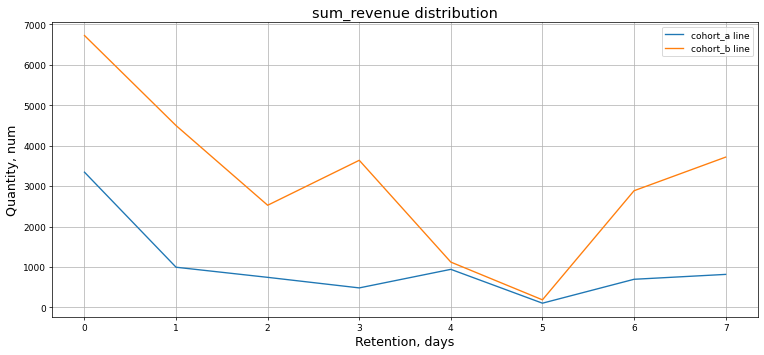

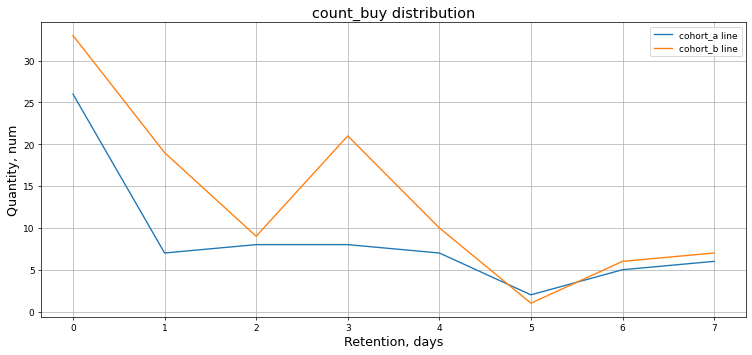

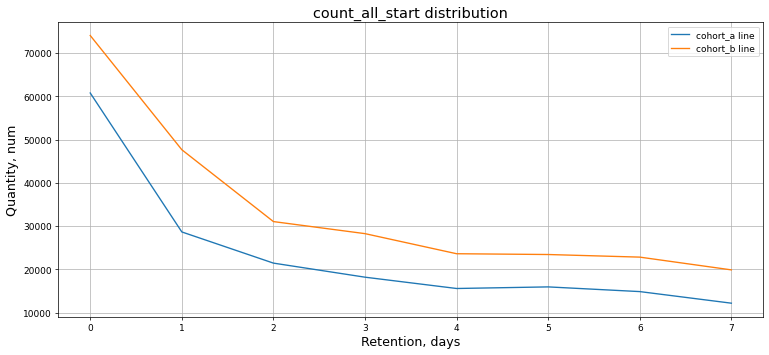

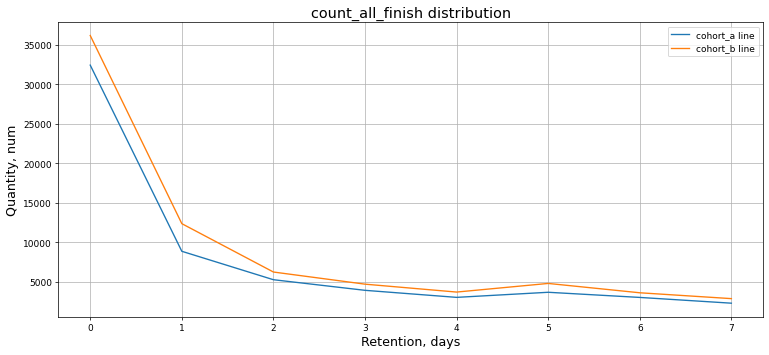

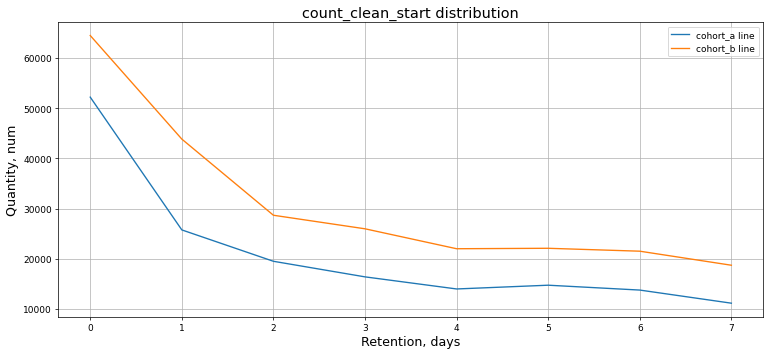

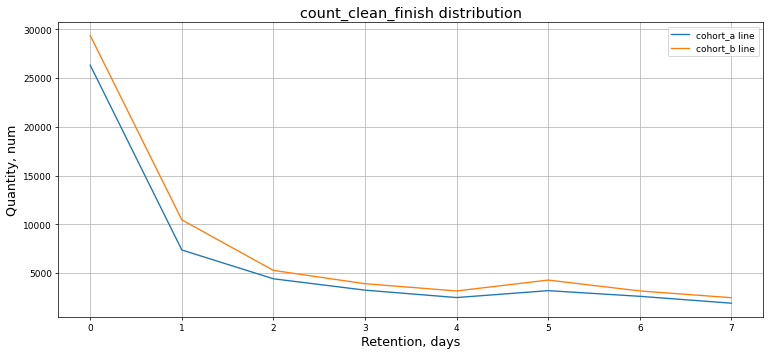

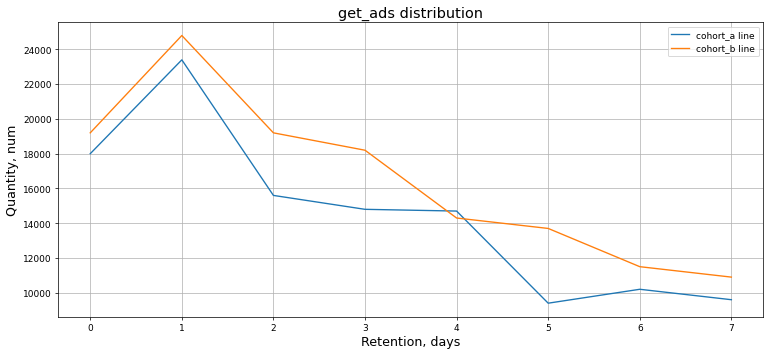

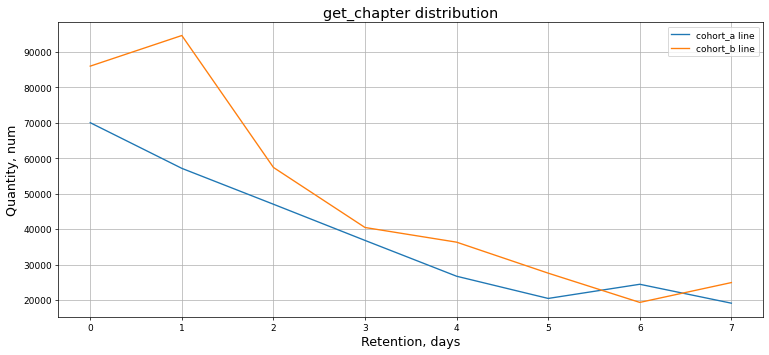

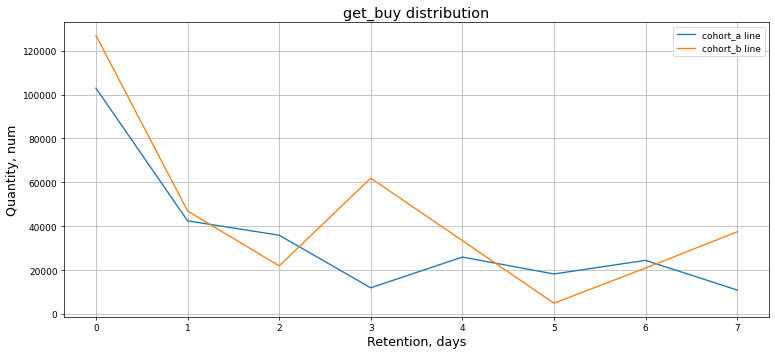

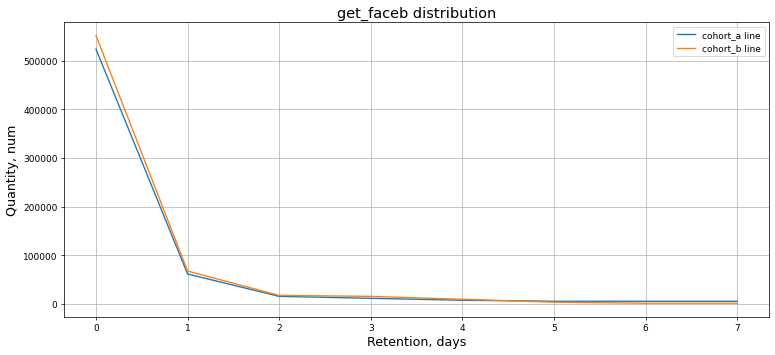

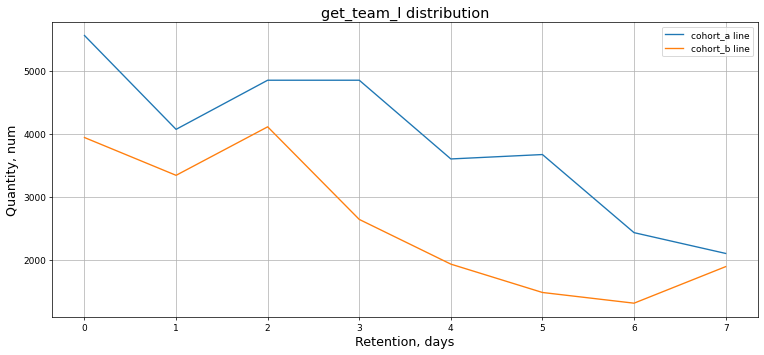

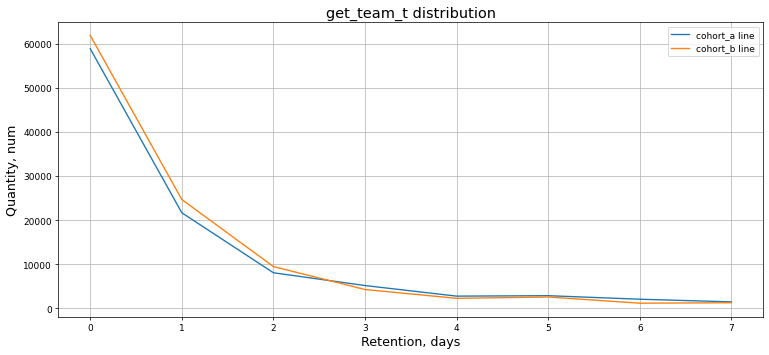

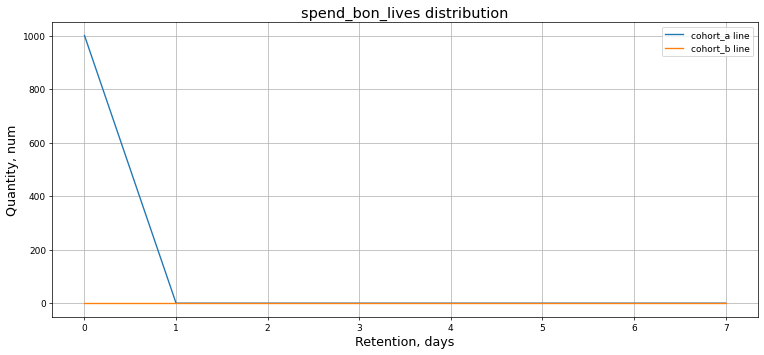

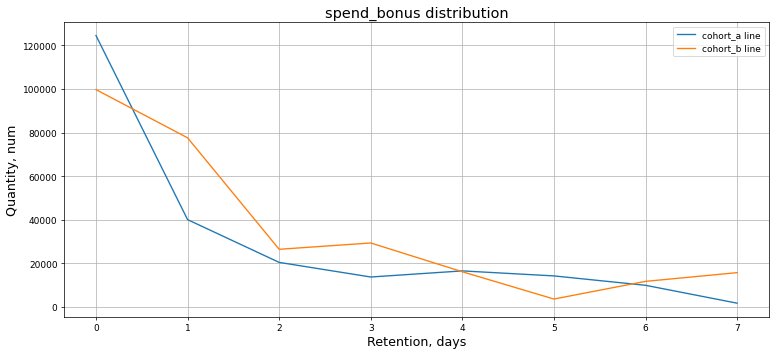

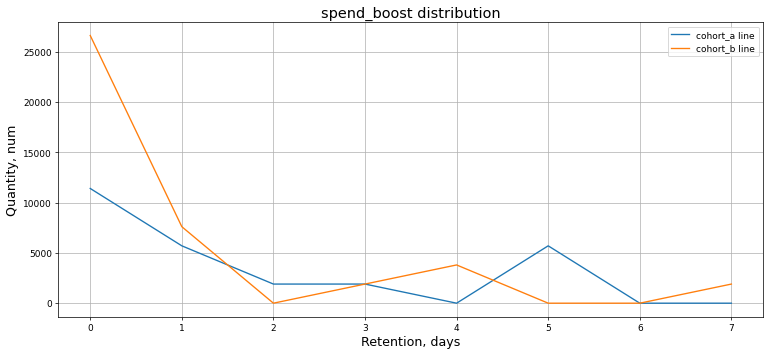

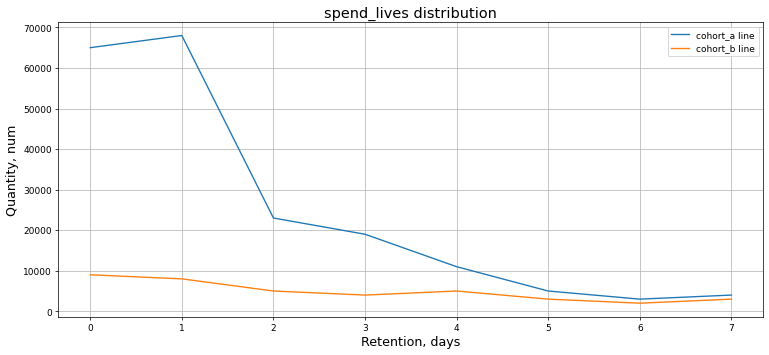

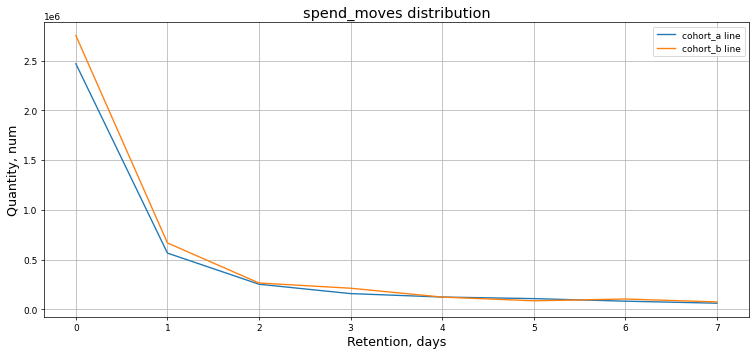

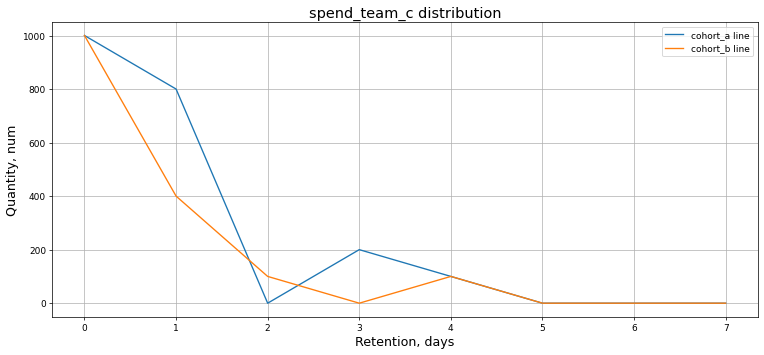

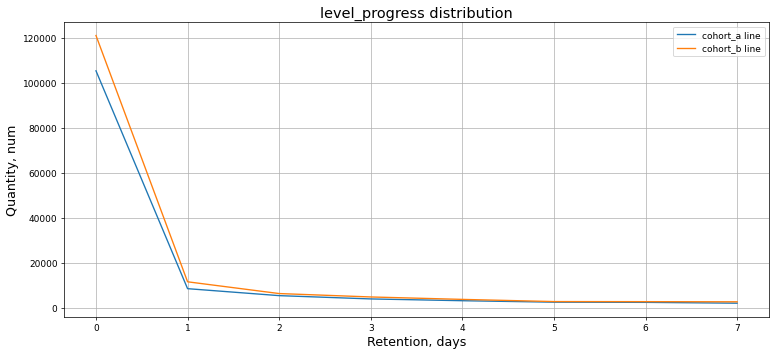

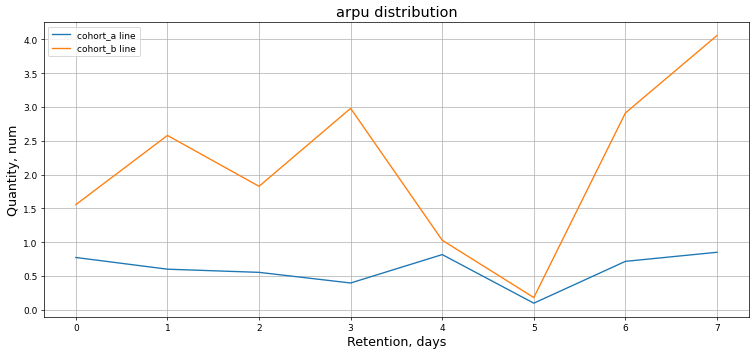

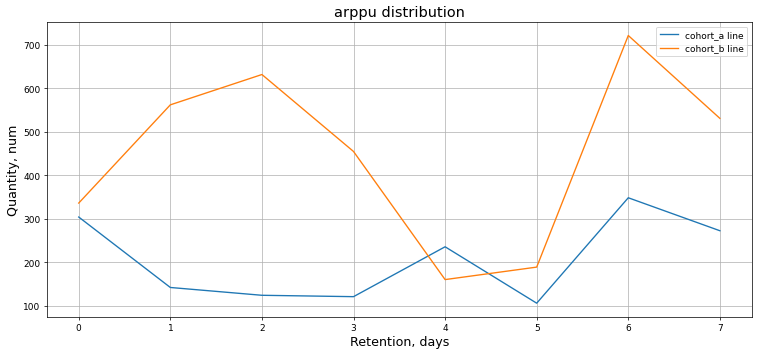

In [22]:
plot_graphs(metrics_a, metrics_b)

#### Выводы по анализу графиков:

- на графике sum_revenue distribution у когорты Б наблюдается значительное увеличение значений метрики практически по каждому дню в retention. Для проверки воспользуемся статистическими критериями (часть 3);


- на графике count_buy distribution также наблюдается увеличение значений метрики. Для проверки воспользуемся статистическими критериями (часть 3);


- на графиках count_all_start, count_all_finish, count_clean_start и count_clean_finish ничего необычного - у когорты Б значение метрик немного выше из-за уменьшеного времени восстановления одной жизни;


- по графикам get_ads и get_buy distribution нельзя с уверенностью сказать, что уменьшение времени восстановления одной жизни повлияло на метрики, хотя в среднем значения метрик у когорты Б немного выше;


- на графике get_chapter distribution наблюдается незначительное увеличение метрики у когорты Б, в первые дни по retention;


- на графиках get_faceb, get_team_t, spend_bon_lives, spend_bonus, spend_boost, spend_moves и spend_team_c у когорты Б не наблюдается изменений;


- добавленная нами метрика level_progress не показывает существенной разницы между когортами;


- на графике get_team_l distribution у когорты Б замечено уменьшение метрики. Для понимания причины требуется плотнее ознакомится с проектом;


- на графике spend_lives distribution у когорты Б замечено значительное уменьшение метрики, показывающее, что у пользователей из когорты А не хватает жизней и приходится их докупать; с увеличением retention разрыв нивелируется, что может указывать на то, что пользователь, например, привык к игре, или у него к этому моменту кончилось золото;


- на графике arpu и arppu у когорты Б наблюдаем значительное увеличение метрик, увеличилось как среднее значение revenue по всем пользователям, так и по платящим пользователям. Убедимся в этом с помощью статистических критериев (часть 3).

### Часть 3. Проверка гипотез

#### Гипотеза "Средние значения метрики sum_revenue у когорт А и Б одинаковы"

Сформулируем нулевую гипотезу H0. В данном случае наша гипотеза будет звучать как "Средние значения метрики sum_revenue у когорт А и Б одинаковы", т.е. они равны или близки друг к другу. Тогда альтернативная гипотеза H1 будет "Средние значения метрики sum_revenue у когорты Б выше".

In [23]:
values_cohort_a = metrics_a['sum_revenue']
values_cohort_b = metrics_b['sum_revenue']

Применяем критерий Манна-Уитни. Получаем условную вероятность того, что наша нулевая гипотеза H0 верна, а также автоматически сравниваем полученную условную вероятность с пороговым значением, принятым 0,05. Если пороговое значение выше, мы отвергнем нулевую гипотезу.

In [24]:
def check_mannwhitneyu_ttest(data1, data2, mannwhitneyu=True):
    
    '''
    Функция рассчитывает заданный статистический критерий и 
    сравнивает его с пороговым значением.
    Флажок переключает тест с критерия Манна-Уитни на критерий Стюдента.
    
    '''
    
    if mannwhitneyu:
        results = st.mannwhitneyu(data1, data2)
        
    else:
        results = st.ttest_ind(data1, data2)
        
    print('p-значение:', results.pvalue)
    alpha = 0.05 / 2 # односторонний тест, делим alpha пополам
    if (results.pvalue) > alpha and (data1.mean() < data2.mean()):
        print('Не получилось отвергнуть нулевую гипотезу')
    else:
        print('Отвергаем нулевую гипотезу')

In [25]:
check_mannwhitneyu_ttest(values_cohort_a, values_cohort_b)

p-значение: 0.011974337439879718
Отвергаем нулевую гипотезу


Для проверки используем критерий Стюдента зная, что при достаточном объеме выборки также можно применять и его, даже если выборка не распределена нормально.

In [26]:
check_mannwhitneyu_ttest(values_cohort_a, values_cohort_b, mannwhitneyu=False)

p-значение: 0.017077970593361094
Отвергаем нулевую гипотезу


Таким образом, с условной вероятностью около 98% можно сделать вывод, что средние значения метрики sum_revenue у когорты  Б выше.

#### Гипотеза "Средние значения метрики count_buy у когорт А и Б одинаковы"

Сформулируем нулевую гипотезу H0. Здесь наша гипотеза будет звучать как "Средние значения метрики count_buy у когорт А и Б одинаковы", т.е. они равны или близки друг к другу. Тогда альтернативная гипотеза H1 будет "Средние значения метрики count_buy у когорты Б выше".

In [27]:
values_cohort_a = metrics_a['count_buy']
values_cohort_b = metrics_b['count_buy']

In [28]:
check_mannwhitneyu_ttest(values_cohort_a, values_cohort_b)

p-значение: 0.14574142450306987
Не получилось отвергнуть нулевую гипотезу


Для проверки воспользуемся критерием Стюдента.

In [29]:
check_mannwhitneyu_ttest(values_cohort_a, values_cohort_b, mannwhitneyu=False)

p-значение: 0.3197033093296359
Не получилось отвергнуть нулевую гипотезу


Такам образом, с условной вероятностью от 15 до 32%, такое или большее различие нельзя получить случайно. Это слишком большая вероятность, чтобы делать вывод о значимом различии между данной метрикой когорт. 

#### Гипотеза "Средние значения метрики get_ads у когорт А и Б одинаковы"

Сформулируем нулевую гипотезу H0. Здесь наша гипотеза будет звучать как "Средние значения метрики get_ads у когорт А и Б одинаковы", т.е. они равны или близки друг к другу. Тогда альтернативная гипотеза H1 будет "Средние значения метрики get_ads у когорты Б выше".

In [30]:
values_cohort_a = metrics_a['get_ads']
values_cohort_b = metrics_b['get_ads']

In [31]:
check_mannwhitneyu_ttest(values_cohort_a, values_cohort_b)

p-значение: 0.1858387234565368
Не получилось отвергнуть нулевую гипотезу


Для проверки воспользуемся критерием Стюдента.

In [32]:
check_mannwhitneyu_ttest(values_cohort_a, values_cohort_b, mannwhitneyu=False)

p-значение: 0.4116329600818488
Не получилось отвергнуть нулевую гипотезу


Такам образом, с условной вероятностью от 19 до 41%, такое или большее различие нельзя получить случайно. Это слишком большая вероятность, чтобы делать вывод о значимом различии между данной метрикой когорт.

#### Гипотеза "Средние значения метрики arppu у когорт А и Б одинаковы"

Сформулируем нулевую гипотезу H0. Здесь наша гипотеза будет звучать как "Средние значения метрики arppu у когорт А и Б одинаковы", т.е. они равны или близки друг к другу. Тогда альтернативная гипотеза H1 будет "Средние значения метрики arppu у когорты Б выше".

In [33]:
values_cohort_a = metrics_a['arppu']
values_cohort_b = metrics_b['arppu']

In [34]:
check_mannwhitneyu_ttest(values_cohort_a, values_cohort_b)

p-значение: 0.009064503932485991
Отвергаем нулевую гипотезу


Для проверки воспользуемся критерием Стюдента.

In [35]:
check_mannwhitneyu_ttest(values_cohort_a, values_cohort_b, mannwhitneyu=False)

p-значение: 0.008862653347254352
Отвергаем нулевую гипотезу


Таким образом, с условной вероятностью около 99% можно сделать вывод, что средние значения метрики arppu у когорты Б выше.

#### Гипотеза "Средние значения метрики spend_lives у когорт А и Б одинаковы"

Сформулируем нулевую гипотезу H0. Здесь наша гипотеза будет звучать как "Средние значения метрики spend_lives у когорт А и Б одинаковы", т.е. они равны или близки друг к другу. Тогда альтернативная гипотеза H1 будет "Средние значения метрики  spend_lives у когорты А выше".

In [36]:
values_cohort_a = metrics_a['spend_lives']
values_cohort_b = metrics_b['spend_lives']

In [37]:
check_mannwhitneyu_ttest(values_cohort_b, values_cohort_a)

p-значение: 0.02851938970137715
Не получилось отвергнуть нулевую гипотезу


Для проверки воспользуемся критерием Стюдента.

In [38]:
check_mannwhitneyu_ttest(values_cohort_b, values_cohort_a, mannwhitneyu=False)

p-значение: 0.05509783183951379
Не получилось отвергнуть нулевую гипотезу


Такам образом, с заданным порогом условной вероятности, такое или большее различие нельзя получить случайно. Это слишком большая вероятность, чтобы делать вывод о значимом различии между данной метрикой когорт.

#### Гипотеза "Средние значения метрики count_all_start у когорт А и Б одинаковы"

Сформулируем нулевую гипотезу H0. Здесь наша гипотеза будет звучать как "Средние значения метрики count_all_start у когорт А и Б одинаковы", т.е. они равны или близки друг к другу. Тогда альтернативная гипотеза H1 будет "Средние значения метрики count_all_start у когорты А выше".

In [39]:
values_cohort_a = metrics_a['count_all_start']
values_cohort_b = metrics_b['count_all_start']

In [40]:
check_mannwhitneyu_ttest(values_cohort_a, values_cohort_b)

p-значение: 0.02601480881111259
Не получилось отвергнуть нулевую гипотезу


Для проверки воспользуемся критерием Стюдента.

In [41]:
check_mannwhitneyu_ttest(values_cohort_a, values_cohort_b, mannwhitneyu=False)

p-значение: 0.24713473289179838
Не получилось отвергнуть нулевую гипотезу


Такам образом, с заданным порогом условной вероятности, такое или большее различие нельзя получить случайно. Это слишком большая вероятность, чтобы делать вывод о значимом различии между данной метрикой когорт.

### Часть 4. Общий вывод

#### Влияние уменьшения времени восстановления жизней на основные метрики проекта

На большинстве метрик проекта сказалось уменьшение времени восстановления жизней. Можно выделить три категории метрик, в зависимости от меры влияния изменений:


- метрики sum_revenue, arpu и arppu. Эти метрики увеличились значительно, тесты показали высокую условную вероятность того, что у когорты Б данные метрики выше, чем у когорты А.


- метрики count_buy, count_all_start, count_all_finish, count_clean_start, count_clean_finish, get_ads,	get_chapter,	get_buy, get_team_l, spend_bonus, spend_boost, spend_lives и spend_team_c. Эти метрики изменились, однако тесты не показали статистической значимости между когортами. Нельзя с уверенностью сказать, что показанные изменения не были случайными.


- метрики get_faceb, get_team_t, spend_bon_lives, spend_moves и level_progress. Эти метрики не показали изменений.


Единственным минусом уменьшения времени восстановления жизней является возможность быстро пройти все имеющиеся уровни. На данной стадии проект предлагает большое количество уровней; метрика level_progress также показывает, что скорость прохождения игры при уменьшении времени восстановления жизней изменяется незначительно. При этом основные метрики проекта sum_revenue, arpu и arppu на А/Б тесте показали значительный рост. 

Рекомендуется уменьшить время восстановления жизней как изменение, благотворно влияющее на качество проекта.

#### Выявленные дефекты датасета, связанные со сбором данных

Как можно заметить ниже, у нас есть пользователи, максимальный пройденный уровень у которых 46 (пользователи 1, 2 и 6), при этом количество стартов и побед на уровнях у них значительно ниже (0, 1). У остальных пользователей похожая ситуация. В целом только пользователи 3 и 8 из представленных ниже выглядят нормально. Также значения в max_level_passed не всегда идут по возрастанию. Эти дефекты могут быть связаны с ошибками в приходящих данных.

In [42]:
df[df['ab_cohort'] == 'A'].groupby(['user_id', 'retention']).sum().head(10)

,,max_level_passed,sum_revenue,count_buy,count_all_start,count_all_finish,count_clean_start,count_clean_finish,get_ads,get_chapter,get_buy,get_faceb,get_team_l,get_team_t,spend_bon_lives,spend_bonus,spend_boost,spend_lives,spend_moves,spend_team_c
user_id,retention,,,,,,,,,,,,,,,,,,,
1,0,46,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,46,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,15,0,0,18,15,14,11,0,0,0,0,0,0,0,0,0,0,0,0
4,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,35,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,0,46,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,0,17,0,0,48,26,41,22,0,0,0,0,0,0,0,0,0,0,2970,0
9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
